Take a time series view of the fluxes. Compute the correlation time scale.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
from aerobulk.flux import noskin_np, skin_np, noskin, skin
from mlflux.gotm import read2010

%load_ext autoreload
%autoreload 3

### From PSD ship data

In [ ]:
''' Observations for reference. '''
path = '/scratch/jw8736/gotm/shared/'

from mlflux.gotm import read_vars
file_swr = {'filename':'swr.dat', 'columns':['swr']}
file_Q = {'filename':'heatflux.dat', 'columns':['Q']}
files = [file_Q]
df = read_vars (path, files, datetimeformat='%Y-%m-%d %H:%M:%S')

df = df.set_index('datetime')
ds_obs = xr.Dataset.from_dataframe(df)

In [ ]:
fig = plt.figure(figsize=[24,4], dpi=200)
folder = '/scratch/jw8736/gotm/test/'
method = 'kpp'
year = 2012
MINUTE = 60
ds = xr.open_dataset(folder + f'{method}_{year}_dt%g.nc' %MINUTE)   
flux = ds.Q.sel(t=slice('2012-01-01','2012-01-31'))
flux.plot()
filtered_flux = flux.rolling(t=24, center=True).mean()
filtered_flux.plot()
(flux-filtered_flux).plot()

In [ ]:
''' Check again if correlation depends on removing trend or not. '''
# compute correlation
def compute_corr (ds, FILTER=True, twindow=48):
    if FILTER:
        signal_interp = ds.Q.values - ds.Q.rolling(t=twindow, center=True).mean().fillna(0).values
    else:
        signal_interp = ds.Q.values       
    signal_interp = signal_interp - np.mean(signal_interp) # normalize the series
    correlation = np.correlate(signal_interp, signal_interp, mode='same')/np.sum(signal_interp**2)
    corr = correlation[int(len(correlation)/2):(int(len(correlation)/2)+200)]
    return corr

plt.plot(compute_corr(ds,FILTER=False), c='k', alpha=0.5)
for i in np.array([2,7,14,30]):
    plt.plot(compute_corr(ds, FILTER=True, twindow=24*i), '--', alpha=0.5, label=f'twindow={i} day')

plt.legend()

# fit a correlation time
# k = np.argmin(abs(corr-np.exp(-1)))
# plt.axvline(x=k, color='k', ls='--')
# T = 1/(1 - np.exp(-1/k)) # phi = exp(-1/k) = 1 - Delta_t/T
# print('e-folding time steps: %g, correlation time T: %g hrs' %(k,T))
# # a different way to fit correlation time
# T = 1/(1 - corr[1])
# print('correlation time from lag-1 T: %g hrs' %(T))

### From OWS Papa data 
ANN and bulk algorithms are pretty close so it's mostly from the correlation of input variables.
TO-DO: rewrite this.

points after linear interp: 87450
e-folding time steps: 18, correlation time T: 18.5046 hrs
correlation time from lag-1 T: 32.0253 hrs


(0.0, 200.0)

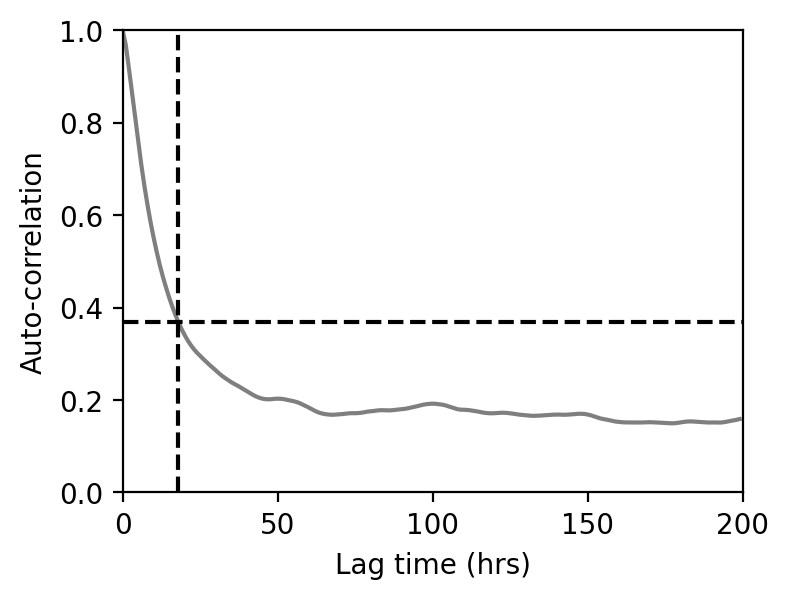

In [114]:
''' Bulk (change variables between heat and momentum) '''
fig = plt.figure(figsize=[4,3], dpi=200)
dur = 80000

for i in (0,):  
    # interpolate onto uniform series
    # buoyancy
    # signal = df.qh[i:(i+dur)] - df.lwr[i:(i+dur)]
    # momentum
    signal = (df_.taux**2+df_.tauy**2)**0.5; signal = signal[i:(i+dur)] # df_ is df with index reset

    signal_interp = signal.resample('h').interpolate(method='linear')
    print('points after linear interp: %g' %len(signal_interp))
    
    # compute correlation
    signal_interp = signal_interp - np.mean(signal_interp) # normalize the series
    correlation = np.correlate(signal_interp, signal_interp, mode='same')/np.sum(signal_interp**2)
    corr = correlation[int(len(correlation)/2):(int(len(correlation)/2)+200)]
    plt.plot(corr, c='k', alpha=0.5)
    
    # fit a correlation time
    k = np.argmin(abs(corr-np.exp(-1)))
    plt.axvline(x=k, color='k', ls='--')
    T = 1/(1 - np.exp(-1/k)) # phi = exp(-1/k) = 1 - Delta_t/T
    print('e-folding time steps: %g, correlation time T: %g hrs' %(k,T))
    # a different way to fit correlation time
    T = 1/(1 - corr[1])
    print('correlation time from lag-1 T: %g hrs' %(T))
    
plt.axhline(y=np.exp(-1.), color='k', ls='--')

plt.ylabel('Auto-correlation'); plt.ylim([0,1])
plt.xlabel('Lag time (hrs)'); plt.xlim([0,200])

e-folding time steps: 19, correlation time T: 19.5044 hrs
correlation time from lag-1 T: 37.266 hrs


(0.0, 200.0)

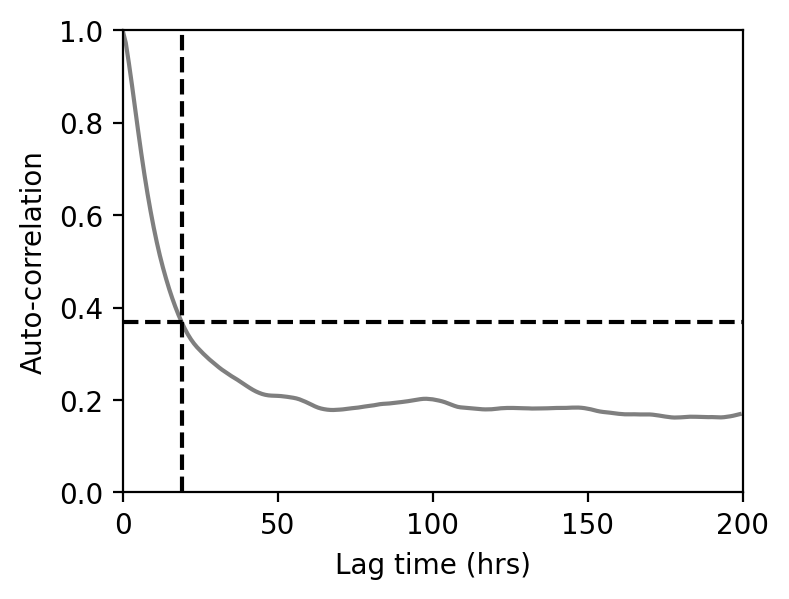

In [133]:
''' ANN (already resampled to hourly when computing flux outputs so no need to interpolate again. '''
fig = plt.figure(figsize=[4,3], dpi=200)
dur = 90000
df_ = df.set_index('datetime')

for i in (0,):  
    # interpolate onto uniform series
    # buoyancy
    # signal_interp = qh_mean + ql_mean
    # momentum
    signal_interp = tau_mean; signal_interp = signal_interp[i:(i+dur)]
    
    # compute correlation
    signal_interp = signal_interp - np.mean(signal_interp) # normalize the series
    correlation = np.correlate(signal_interp, signal_interp, mode='same')/np.sum(signal_interp**2)
    corr = correlation[int(len(correlation)/2):(int(len(correlation)/2)+200)]
    plt.plot(corr, c='k', alpha=0.5)
    
    # fit a correlation time
    k = np.argmin(abs(corr-np.exp(-1)))
    plt.axvline(x=k, color='k', ls='--')
    T = 1/(1 - np.exp(-1/k)) # phi = exp(-1/k) = 1 - Delta_t/T
    print('e-folding time steps: %g, correlation time T: %g hrs' %(k,T))
    # a different way to fit correlation time
    T = 1/(1 - corr[1])
    print('correlation time from lag-1 T: %g hrs' %(T))
    
plt.axhline(y=np.exp(-1.), color='k', ls='--')

plt.ylabel('Auto-correlation'); plt.ylim([0,1])
plt.xlabel('Lag time (hrs)'); plt.xlim([0,200])